In [84]:
import pandas as pd

In [85]:
df = pd.read_csv('./data/train_sessions.csv', index_col=0)
df.head(1)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [86]:
df['n'] = df.apply(lambda row: (len(row.dropna()) - 1)/2, axis=1)

In [87]:
for col in df.columns:
    if col.startswith('site'):
        df[col] = df[col].fillna(-1).astype(int)

In [88]:
log = pd.read_csv('./data/train/Alice_log.csv')
alice_sites = df[df.target == 1][[col for col in df.columns if col.startswith('site')]]
sites = []
for col in df.columns:
    if (col.startswith('site')) & (col != 'sites_n'):
        sites += list(df[col].values)

In [89]:
sites = [s for s in sites if s!=-1]
len(sites)

2412880

In [90]:
import pickle
with open('./data/site_dic.pkl', 'rb') as pf:
    sitedic = pickle.load(pf)
sitedict = {sitedic[k]: k for k in sitedic.keys()}

In [91]:
for col in df.columns:
    if col.startswith('site'):
        df[col] = df[col].map(sitedict)

In [95]:
sitecols = [col for col in df.columns if col.startswith('site')]

In [187]:
def get_sites_list(row):
    names, domains = '', ''
    for s in row.dropna().values:
        sp = s.split('.')
        name, domain = ' '.join(sp[:-1]), sp[-1]
        names += name + ' '
        domains += domain + ' '
        
    return pd.Series([names, domains])

df[['sites_line', 'domains']] = df[sitecols].apply(get_sites_list, axis=1)

In [208]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, stratify=df.target)

In [209]:
X_train.shape, X_test.shape

((202848, 24), (50713, 24))

In [188]:
from sklearn.feature_extraction.text import CountVectorizer
cvect = CountVectorizer()
cvect.fit(' '.join(s.split('.')[:-1]) for s in list(sitedic.keys()))    

cvect_domain = CountVectorizer()
cvect_domain.fit([s.split('.')[-1] for s in sitedic.keys()])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [210]:
from sklearn.pipeline import FeatureUnion
feat_sites = cvect.transform(X_train.sites_line)
feat_domains = cvect_domain.transform(X_train.domains)

In [211]:
from scipy import sparse
feat = sparse.hstack((feat_sites, feat_domains))

In [221]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(class_weight='balanced')
clf.fit(feat, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [222]:
from sklearn import metrics
feat_sites_test = cvect.transform(X_test.sites_line)
feat_domains_test = cvect_domain.transform(X_test.domains)
feat_test = sparse.hstack((feat_sites_test, feat_domains_test))

In [224]:
metrics.roc_auc_score(clf.predict(feat_test), y_test)

0.54013779717740928

In [237]:
import datetime as dt
df['hour1'] = df.time1.apply(lambda x: int(x.split()[1][:2]))
df.groupby('target').hour1.mean()

target
0    12.259731
1    15.433609
Name: hour1, dtype: float64

C:\Users\nryabykh\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


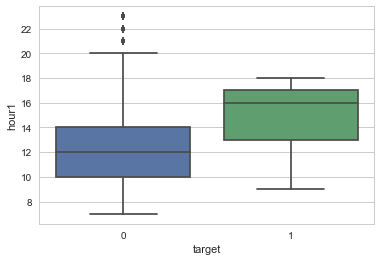

In [239]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
sns.boxplot(x='target', y='hour1', data=df)

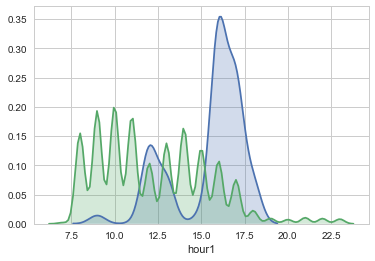

In [250]:
sns.distplot(df[df.target == 1].hour1, hist=False, kde_kws={"shade": True})
sns.distplot(df[df.target == 0].hour1, hist=False, kde_kws={"shade": True})

In [261]:
%time dt.datetime.strptime(df.iloc[0].time1, '%Y-%m-%d %H:%M:%S')

Wall time: 0 ns


datetime.datetime(2014, 2, 20, 10, 2, 45)

In [263]:
for col in df.columns:
    if col.startswith('time'):
        df[col] = pd.to_datetime(df[col])

In [276]:
df['duration'] = df[[col for col in df.columns if col.startswith('time')]].apply(lambda row: (max(row)-min(row)).seconds, axis=1)

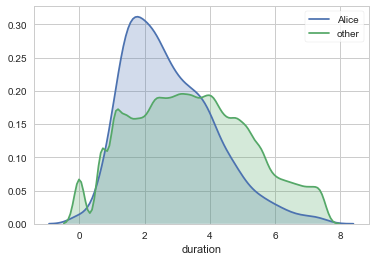

In [280]:
sns.distplot(df[df.target == 1].duration.apply(np.log1p), hist=False, kde_kws={"shade": True}, label='Alice')
sns.distplot(df[df.target == 0].duration.apply(np.log1p), hist=False, kde_kws={"shade": True}, label='other')
plt.legend(frameon=True)

In [287]:
X_train, X_test, y_train, y_test = train_test_split(df[['duration', 'hour1']], df.target, test_size=0.3, stratify=df.target)

In [288]:
clf.fit(X_train, y_train)
metrics.roc_auc_score(clf.predict(X_test), y_test)

0.50949419927872674

In [293]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X_train, y_train)
y_train.value_counts()

0    175884
1      1608
Name: target, dtype: int64